# UE 12
## Ziele der Übung: 

### 1. Weiterentwicklund des Modells wiederholen

### 2. Import/Export zu anderen Regionen einbauen 
---

#### Bibliotheken einlesen
- numpy: "Numerical Python" 
- pandas: Package for Datahandling
- gurobipy: Package for linear optimization
- matplotlib.pyplot: Package for plotting Data 

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *

#### 1. Residuallast berechnen
- Last und EE-Erzeugung aus .csv-Dateien einlesen
- in Dataframe speichern und Zeitstempel erstellen
- Residuallast berechnet (Last-EE) und in neuem Dataframe speichern
- Residuallast plotten

### Last

In [176]:
# Import csv
year = 2015
path_load = './Input/Load_'+str(year)+'.csv'
#path = './Input/Load_2015.csv'

# Read from csv
df_load = pd.read_csv(path_load, sep=';', decimal=',')
df_load.tail()

,Datum,Zeit,Wert in MW
35040,31.12.2015,23:00,1632
35041,31.12.2015,23:15,1760
35042,31.12.2015,23:30,1648
35043,31.12.2015,23:45,1792
35044,31.12.2015,00:00,1664


In [177]:
# Create column including date and time
df_load['Timestamp'] = df_load['Datum']+" "+df_load['Zeit']
# Create timestamp from column
df_load['Timestamp'] = pd.to_datetime(df_load['Timestamp'], utc='Europe/Berlin')
# Set index to timestamp
df_load.set_index('Timestamp', inplace=True)
# Drop columns Datum and Zeit
df_load.drop(['Datum','Zeit'], axis=1, inplace=True)
df_load.head()

,Wert in MW
Timestamp,
2015-01-01 00:00:00+00:00,1664
2015-01-01 00:15:00+00:00,2224
2015-01-01 00:30:00+00:00,2064
2015-01-01 00:45:00+00:00,2224
2015-01-01 01:00:00+00:00,2144


### EE-Erzeugung

In [178]:
# Import csv
year = 2015
path_EE = './Input/EE_gen_'+str(year)+'.csv'
# Read from csv
df_EE = pd.read_csv(path_EE, sep=';', decimal=',')
df_EE.tail()

,cet_cest_timestamp,actual_Solar,actual_wind
35035,2015-12-31T23:45:00+0100,0.0,607.5
35036,2016-01-01T00:00:00+0100,0.0,600.9
35037,2016-01-01T00:15:00+0100,0.0,588.0
35038,2016-01-01T00:30:00+0100,0.0,579.0
35039,2016-01-01T00:45:00+0100,0.0,573.3


In [179]:
# Set datetime format
df_EE['cet_cest_timestamp'] = pd.to_datetime(df_EE['cet_cest_timestamp'], utc='Europe/Berlin')
# Set index
df_EE.set_index('cet_cest_timestamp', inplace=True)
df_EE.head()

,actual_Solar,actual_wind
cet_cest_timestamp,,
2015-01-01 00:00:00+00:00,0.0,683.4
2015-01-01 00:15:00+00:00,0.0,692.7
2015-01-01 00:30:00+00:00,0.0,692.4
2015-01-01 00:45:00+00:00,0.0,701.1
2015-01-01 01:00:00+00:00,0.0,711.3


### Residuallast

In [180]:
# Create new dataframe
df_res_load = pd.DataFrame()
df_res_load['Residuallast in MW'] = df_load['Wert in MW'] - df_EE['actual_Solar'] - df_EE['actual_wind']

df_res_load.head()

,Residuallast in MW
2015-01-01 00:00:00+00:00,980.6
2015-01-01 00:00:00+00:00,1492.6
2015-01-01 00:15:00+00:00,1531.3
2015-01-01 00:30:00+00:00,1371.6
2015-01-01 00:45:00+00:00,1522.9


### Auswahl einer Woche

In [181]:
# Create new dataframe
# Define week
week = 10
# New dataframe
df_res_load_cropped = pd.DataFrame()
# mask df_res_load
mask = df_res_load.index.week == week
# Copy df_res_load where week is 10
df_res_load_cropped = df_res_load.loc[mask]
# Resample to hourly load
df_res_load_cropped = df_res_load_cropped.resample('h').mean()

df_res_load_cropped.head()

,Residuallast in MW
2015-03-02 00:00:00+00:00,1063.350
2015-03-02 01:00:00+00:00,881.375
2015-03-02 02:00:00+00:00,748.850
2015-03-02 03:00:00+00:00,566.025
2015-03-02 04:00:00+00:00,526.075


### Residuallast plotten

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


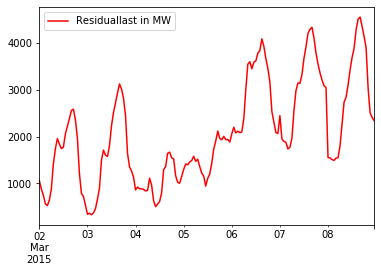

In [182]:
df_res_load_cropped.plot(kind='line', c='r', style ='-')
plt.show()

## 2. Modellierung
- Kraftwerksparameter aus .csv-Datei einlesen
- Modell aufstellen
    - Kraftwerksparameter definiern
    - Variablen definieren
    - Nebenbedingungen einfügen, die durch die Parameter der KW definiert werden
        - Maximale Leistung / Minimale Leistung
        - Emissionen / CO2-Kosten --> Kosten 0.02 €/kg, Limit 3.500.000.000.000.000 kg_CO2/MWh_el
        - Nachfrage
        - Start-Up Costs
        - Speicher
            - in t=0 leer
            - max. 200 MWh
    - Zielfunktion festlegen

### Kraftwerksparameter

In [622]:
# Define path
path_PP = './Input/PP_List.csv'
# read csv
df_PP = pd.read_csv(path_PP, sep=';', decimal=',')
df_PP

,Fuel,Pmax in MW,Pmin in MW,variable costs in EUR/MWh,startup cost in EUR,fix operating cost in EUR/h,Emissionsfaktor kg_CO2/MWh_el
0,Biomass,82,1.00,50,10,4600,0
1,Gas,1450,1.00,35,280,3800,455
2,Hard_Coal,1487,223.05,15,420,7000,891
3,Lignite,1320,264.00,6,420,7800,1225
4,Uranium,666,219.78,5,10000,11000,0
5,Oil,135,1.00,38,280,3800,776
6,Water,146,1.00,0,1,5000,0


#### Preis im Ausland

,Price
timestep,
2015-03-02 00:00:00+00:00,12.091896
2015-03-02 01:00:00+00:00,3.280788
2015-03-02 02:00:00+00:00,4.000000
2015-03-02 03:00:00+00:00,4.000000
2015-03-02 04:00:00+00:00,4.000000


### Modell erstellen

In [736]:
# Create Model
M = Model('Unit Commitment')

### Parameter

In [747]:
# Load
load_model = df_res_load_cropped['Residuallast in MW'].copy()

# Power Plants
PP_model = df_PP.copy()

# Pmax
P_max = PP_model['Pmax in MW']

# Pmin
P_min = PP_model['Pmin in MW']

# cost
cost_var = PP_model['variable costs in EUR/MWh']
cost_su = PP_model['startup cost in EUR']
cost_fix = PP_model['fix operating cost in EUR/h']

# emissions
e_factor = PP_model['Emissionsfaktor kg_CO2/MWh_el']
e_cost = 0.025 # in EUR/kg
e_limit = 3500000000000000 # in kg CO2

# Storage
S_max = 200 # maximales Speichervolumen in MWh
S_0 = 0 #initialer Speicherstand in t=0

# Import/Export

# Price in other market

# Sets for Timesteps and Powerplants
T = range(len(df_res_load_cropped))
I = range(len(df_PP))

### Variablen

In [748]:
# Production
X = M.addVars(T, I, vtype=GRB.CONTINUOUS, name='Production of PP i in timestep t')

# Power Plant Status, 1 = operating, 0 = not operating
Y = M.addVars(T, I, vtype=GRB.BINARY, name='Status of PP i in timestep t')

# Start-up Status, 1 = start-up, 0 = not start-up
SU = M.addVars(T, I, vtype=GRB.BINARY, name='Indicator of PP i is starting up in timestep t')

# Emissions (define variable for easier use later on)
E = M.addVars(T, I, vtype=GRB.CONTINUOUS, name='Emissions of PP i in timestep t')

# Import 

#Export

# Storage
S_lvl = M.addVars(T, vtype=GRB.CONTINUOUS, name='Storage level in timestep t')
S_in = M.addVars(T, vtype=GRB.CONTINUOUS, name='Added Storage in timestep t')
S_out = M.addVars(T, vtype=GRB.CONTINUOUS, name='Storage out in timestep t')

### Nebenbedingungen
- Maximale und minimale Erzeugung
- Start-up Status
- Emissionen
- Speicher
    - Maximaler Speicherstand
    - ***NEU***: Bilanz für t=0 (Level_0 = S_0 + S_in_0 - S_out_0)
    - Bilanz für jedes t > 0 (Level_t = Level_t-1 + S_in_t - S_out_t)
- Deckung der Nachfrage

In [749]:
# Erzeugung
# Pmax
M.addConstrs((X[t,i] <= P_max[i]*Y[t,i] for t in T for i in I), name='Constr 1')
# Pmin
M.addConstrs((X[t,i] >= P_min[i]*Y[t,i] for t in T for i in I), name='Constr 2')
M.update()

In [750]:
# Start-up
# t = 0 --> alle vorher aus
M.addConstrs((SU[0,i] == Y[0,i] for i in I), name='Constr 3')
# for t > 0
M.addConstrs((SU[t,i] >= Y[t,i]-Y[t-1,i] for t in T for i in I if t>0), name='Constr 4')
M.update()

In [751]:
# Emission
M.addConstrs((E[t,i] == e_factor[i]*X[t,i] for t in T for i in I), name='Constr 5')
# Limit
M.addConstr((quicksum(E[t,i] for t in T for i in I) <= e_limit), name = "Constr 6")
M.update()

In [752]:
# Speicher
# S_max
M.addConstrs((S_lvl[t] <= S_max for t in T), name='Constr 7')
# t=0
M.addConstr((S_lvl[0] == S_0 + S_in[0]-S_out[0]), name='Constr 8')
# Bilanz t>0
M.addConstrs((S_lvl[t] == S_lvl[t-1]+S_in[t]-S_out[t] for t in T if t>0), name ='Constr 9')
M.update()

In [753]:
# Import/Export


In [754]:
# Load
M.addConstrs((quicksum(X[t,i] for i in I) + S_out[t] - S_in[t] + Im[t] - Ex[t] >= load_model[t] for t in T), name='Constr 13')
M.update()

### Zielfunktion

In [755]:
M.setObjective(quicksum(X[t,i]*cost_var[i] # Variable Kosten
                        + Y[t,i]*cost_fix[i] # Fixkosten, falls produziert wird
                        + SU[t,i]*cost_su[i] # Startup Kosten, falls hochgefahren wird
                        + E[t,i]*e_cost # Emissionskosten
                        + C_Im[t] # Importkosten
                        - C_Ex[t] # Exporterlöse
                        for i in I for t in T), GRB.MINIMIZE)

### Optimierung

In [756]:
M.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 11426 rows, 11760 columns and 29888 nonzeros
Model fingerprint: 0x39f012fc
Variable types: 7056 continuous, 4704 integer (4704 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e-02, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+01, 4e+15]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start from previous solve produced solution with objective 1.22489e+07 (0.17s)
MIP start from previous solve produced solution with objective 1.1879e+07 (0.19s)
MIP start from previous solve produced solution with objective 1.17498e+07 (0.37s)
MIP start from previous solve produced solution with objective 1.17427e+07 (0.49s)
MIP start from previous solve produced solution with objective 1.16733e+07 (0.60s)
MIP start from previous solve produced solution with objective 1.16659e+07 (0.84s)
MIP start from previou

### Ergebnisse: Produktion

In [758]:
# Save production to matrix
matrix= []
for t in T:
    array = []
    for i in I:
        array.append(X[t,i].X)
    matrix.append(array)
# Convert matrix to Dataframe
Production = pd.DataFrame(matrix)
# Rename columns
Production.columns = ['Biomasse', 'Gas', 'Steinkohle', 'Braunkohle', 'Uran', 'Öl', 'Wasser']
# Set index to timestamp
Production.set_index(df_res_load_cropped.index, inplace=True)

Production.head()

,Biomasse,Gas,Steinkohle,Braunkohle,Uran,Öl,Wasser
2015-03-02 00:00:00+00:00,0.0,331.35,0.0,0.0,666.0,0.0,146.0
2015-03-02 01:00:00+00:00,0.0,0.00,0.0,0.0,666.0,0.0,146.0
2015-03-02 02:00:00+00:00,0.0,0.00,0.0,0.0,666.0,0.0,0.0
2015-03-02 03:00:00+00:00,0.0,0.00,0.0,0.0,666.0,0.0,0.0
2015-03-02 04:00:00+00:00,0.0,0.00,0.0,0.0,666.0,0.0,0.0


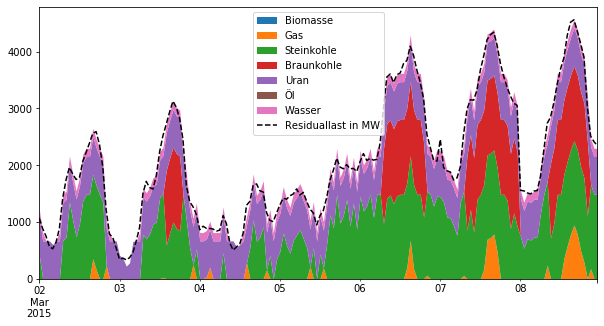

In [729]:
fig, ax = plt.subplots(figsize=(10,5))
Production.plot.area(ax=ax, stacked=True, linewidth=0)
df_res_load_cropped.plot(ax=ax, style='--', c='k')
plt.show()

### Import/Export

,Import,Export
2015-03-02 00:00:00+00:00,0.000,-80.0000
2015-03-02 01:00:00+00:00,80.000,-0.0000
2015-03-02 02:00:00+00:00,72.225,-0.0000
2015-03-02 03:00:00+00:00,0.000,-0.0000
2015-03-02 04:00:00+00:00,0.000,-39.9000
2015-03-02 05:00:00+00:00,0.000,-36.5125
2015-03-02 06:00:00+00:00,80.000,-0.0000
2015-03-02 07:00:00+00:00,0.000,-80.0000
2015-03-02 08:00:00+00:00,0.000,-80.0000
2015-03-02 09:00:00+00:00,0.000,-80.0000


### Ergebnisse: Speicher

In [771]:
# Save Storage to matrix
matrix= []

for t in T:
    array = []
    array.append(S_in[t].X)
    array.append(S_out[t].X)
    matrix.append(array)
    
# Convert matrix to Dataframe
Storage = pd.DataFrame(matrix)
# Rename columns
Storage.columns = ['S_in', 'S_out']
# Set index to timestamp
Storage.set_index(df_res_load_cropped.index, inplace=True)
# Convert S_in in negative values
Storage['S_in'] *= -1 #Storage['S_in']=Storage['S_in']*-1

Storage.tail()

,S_in,S_out
2015-03-08 19:00:00+00:00,-0.00,0.00
2015-03-08 20:00:00+00:00,-200.00,0.00
2015-03-08 21:00:00+00:00,-0.00,200.00
2015-03-08 22:00:00+00:00,-126.15,0.00
2015-03-08 23:00:00+00:00,-0.00,126.15


### Ergebnisse: Gesamt

In [773]:
df_plot = pd.concat([Production, Storage], axis=1)
df_plot.head()

,Biomasse,Gas,Steinkohle,Braunkohle,Uran,Öl,Wasser,S_in,S_out,Import,Export
2015-03-02 00:00:00+00:00,0.0,331.35,0.0,0.0,666.0,0.0,146.0,-0.000,0.000,0.000,-80.0
2015-03-02 01:00:00+00:00,0.0,0.00,0.0,0.0,666.0,0.0,146.0,-10.625,0.000,80.000,-0.0
2015-03-02 02:00:00+00:00,0.0,0.00,0.0,0.0,666.0,0.0,0.0,-0.000,10.625,72.225,-0.0
2015-03-02 03:00:00+00:00,0.0,0.00,0.0,0.0,666.0,0.0,0.0,-99.975,0.000,0.000,-0.0
2015-03-02 04:00:00+00:00,0.0,0.00,0.0,0.0,666.0,0.0,0.0,-100.025,0.000,0.000,-39.9


In [767]:
df_check = pd.concat([df_plot.sum(axis=1), df_res_load_cropped], axis=1)
df_check.head()

,0,Residuallast in MW
2015-03-02 00:00:00+00:00,1063.350,1063.350
2015-03-02 01:00:00+00:00,881.375,881.375
2015-03-02 02:00:00+00:00,748.850,748.850
2015-03-02 03:00:00+00:00,566.025,566.025
2015-03-02 04:00:00+00:00,526.075,526.075


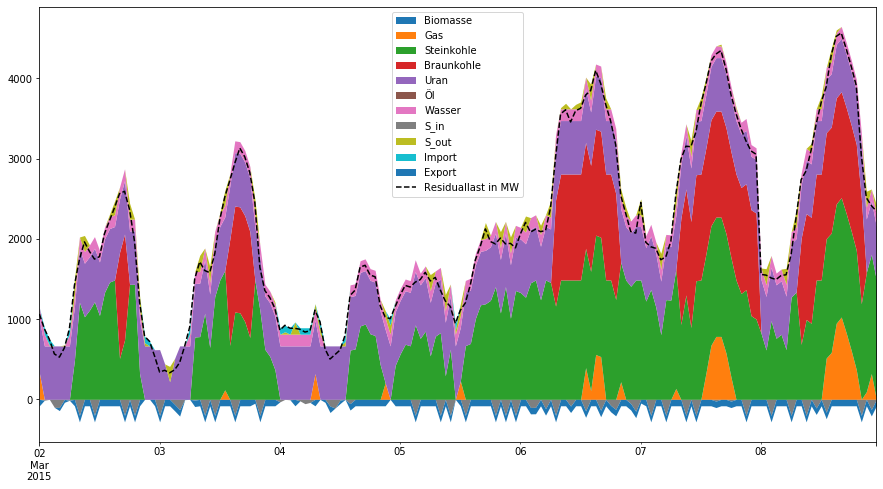

In [770]:
fig, ax = plt.subplots(figsize=(15,8))
df_plot.plot.area(ax=ax, stacked=True, linewidth=0)
df_res_load_cropped.plot(ax=ax, style='--', c='k')

plt.show()

### Ergebnisse: Emissionen

In [768]:
# Save production to matrix
matrix= []
for t in T:
    array = []
    for i in I:
        array.append(E[t,i].X)
    matrix.append(array)
# Convert matrix to Dataframe
Emissionen = pd.DataFrame(matrix)
# Rename columns
Emissionen.columns = ['Biomasse', 'Gas', 'Steinkohle', 'Braunkohle', 'Uran', 'Öl', 'Wasser']
# Set index to timestamp
Emissionen.set_index(df_res_load_cropped.index, inplace=True)

Emissionen.tail()

,Biomasse,Gas,Steinkohle,Braunkohle,Uran,Öl,Wasser
2015-03-08 19:00:00+00:00,0.0,168111.125,1324917.0,1617000.0,0.0,0.0,0.0
2015-03-08 20:00:00+00:00,0.0,0.000,1061448.3,1617000.0,0.0,0.0,0.0
2015-03-08 21:00:00+00:00,0.0,42519.750,1324917.0,0.0,0.0,0.0,0.0
2015-03-08 22:00:00+00:00,0.0,146157.375,1324917.0,0.0,0.0,0.0,0.0
2015-03-08 23:00:00+00:00,0.0,0.000,1324917.0,0.0,0.0,0.0,0.0


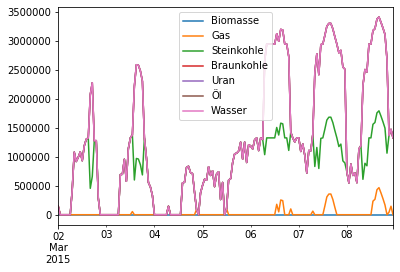

In [769]:
Emissionen.plot(stacked=True)
plt.show()